# Keyword Analysis for Political Topics

This notebook analyzes tweet mentions of specific keywords by party and creates visualizations.

**Example use case:** Analyzing how different parties discuss "Venezuela", "Ukraine", "Klimawandel", etc.

In [17]:
# Import libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from pathlib import Path
import yaml

# Database connection
import sys
sys.path.insert(0, str(Path.cwd().parent / 'src'))
from xminer.io.db import engine
from sqlalchemy import text

In [18]:
# --- Load parameters from config ---
PARAMS_FILE = Path("../src/xminer/config/parameters.yml")
assert PARAMS_FILE.exists(), f"parameters.yml not found: {PARAMS_FILE}"

with PARAMS_FILE.open("r", encoding="utf-8") as f:
    params = yaml.safe_load(f) or {}

YEAR = int(params.get("year", 2025))
MONTH = int(params.get("month", 12))
YM = f"{YEAR:04d}{MONTH:02d}"

# Politicians table - use latest available (December 2025) since January 2026 doesn't exist yet
# This is separate from the display period
POLITICIANS_YEAR = 2025
POLITICIANS_MONTH = 12
POLITICIANS_TABLE = f"politicians_{POLITICIANS_MONTH:02d}_{POLITICIANS_YEAR}"

# Bilingual stand text (shows the data period, not the politicians table)
STAND_TEXT_DE = f"Erhoben für {MONTH:02d}/{YEAR}"
STAND_TEXT_EN = f"Data from {MONTH:02d}/{YEAR}"

def get_stand_text(language='de'):
    return STAND_TEXT_DE if language == 'de' else STAND_TEXT_EN

# Output directory for graphics
GRAPHICS_BASE_DIR = Path(
    params.get(
        "graphics_base_dir",
        "../outputs",
    )
)

GRAPHICS_DIR = GRAPHICS_BASE_DIR / YM / "graphics" / "keywords"
GRAPHICS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Graphics will be saved to: {GRAPHICS_DIR}")
print(f"Display period: {YEAR}-{MONTH:02d}")
print(f"Politicians table: {POLITICIANS_TABLE}")

Graphics will be saved to: /Users/margespinderi/Documents/PoliMetrics/xminer/outputs/202601/graphics/keywords
Display period: 2026-01
Politicians table: politicians_12_2025


In [19]:
# Party colors (consistent with other notebooks)
PARTY_COLORS = {
    "CDU/CSU": "#000000",
    "CDU": "#000000",
    "CSU": "#000000",
    "SPD": "#E3000F",
    "GRÜNE": "#1AA64A",
    "BÜNDNIS 90/DIE GRÜNEN": "#1AA64A",
    "DIE LINKE.": "#BE3075",
    "LINKE": "#BE3075",
    "FDP": "#FFED00",
    "AFD": "#009EE0",
    "BSW": "#009688",
    "FW": "#F28F00",
    "SSW": "#00A3E0",
}

def normalize_party(p: str) -> str:
    """Normalize party names for consistency."""
    if p is None:
        return ""
    key = str(p).strip().upper()
    
    if key in {"CDU", "CSU"}:
        return "CDU/CSU"
    if key.startswith("GRÜN") or "GRUENE" in key or "B90" in key or "BÜNDNIS" in key:
        return "GRÜNE"
    if key in {"LINKE", "DIE LINKE", "DIE LINKE."}:
        return "DIE LINKE."
    return key

def get_party_color(party: str) -> str:
    """Get color for a party."""
    normalized = normalize_party(party)
    return PARTY_COLORS.get(normalized, "#888888")

## Define Keywords to Analyze

In [20]:
# Define keywords to search for (case-insensitive)
# You can modify this list to analyze different topics
KEYWORDS = [
    "Grönland",
    "Greenland", 
    "Venezuela",
    "Ukraine",
    "Klimawandel",
    "Migration",
]

# Or analyze a single keyword in detail
# For Greenland, we search for both German and English variants
SINGLE_KEYWORD = "Grönland"  # Primary keyword for detailed analysis
SINGLE_KEYWORD_VARIANTS = ["Grönland", "Greenland", "Groenland"]  # All variants to include

print(f"Will analyze keywords: {KEYWORDS}")
print(f"\nDetailed analysis for: {SINGLE_KEYWORD}")
print(f"Including variants: {SINGLE_KEYWORD_VARIANTS}")

Will analyze keywords: ['Grönland', 'Greenland', 'Venezuela', 'Ukraine', 'Klimawandel', 'Migration']

Detailed analysis for: Grönland
Including variants: ['Grönland', 'Greenland', 'Groenland']


## Single Keyword Analysis (e.g., Venezuela)

In [21]:
# Query for single keyword by party (including all variants)
# Build WHERE clause for all variants
variant_conditions = " OR ".join([f"t.text ILIKE '%{v}%'" for v in SINGLE_KEYWORD_VARIANTS])

query = f"""
SELECT 
    p.partei_kurz AS party,
    COUNT(*) AS tweet_count,
    COUNT(DISTINCT t.username) AS user_count,
    SUM(t.like_count) AS total_likes,
    SUM(t.retweet_count) AS total_retweets,
    SUM(t.impression_count) AS total_impressions,
    AVG(t.like_count) AS avg_likes,
    AVG(t.impression_count) AS avg_impressions
FROM public.tweets t
JOIN {POLITICIANS_TABLE} p ON LOWER(t.username) = LOWER(p.username)
WHERE {variant_conditions}
GROUP BY p.partei_kurz
ORDER BY tweet_count DESC
"""

print(f"Searching for: {' OR '.join(SINGLE_KEYWORD_VARIANTS)}")

with engine.connect() as conn:
    df_keyword = pd.read_sql(text(query), conn)

# Normalize party names
df_keyword['party_norm'] = df_keyword['party'].apply(normalize_party)

# Aggregate by normalized party
df_keyword_agg = (
    df_keyword.groupby('party_norm')
    .agg({
        'tweet_count': 'sum',
        'user_count': 'sum',
        'total_likes': 'sum',
        'total_retweets': 'sum',
        'total_impressions': 'sum',
        'avg_likes': 'mean',
        'avg_impressions': 'mean'
    })
    .reset_index()
    .sort_values('tweet_count', ascending=False)
)

print(f"\nTweets mentioning '{SINGLE_KEYWORD}' (all variants) by party:")
print(df_keyword_agg[['party_norm', 'tweet_count', 'user_count', 'total_impressions']])
print(f"\nTotal tweets: {df_keyword_agg['tweet_count'].sum()}")
print(f"Total impressions: {df_keyword_agg['total_impressions'].sum():,.0f}")

Searching for: Grönland OR Greenland OR Groenland

Tweets mentioning 'Grönland' (all variants) by party:
   party_norm  tweet_count  user_count  total_impressions
3       GRÜNE           13           7          7969490.0
1     CDU/CSU           12           8          1089495.0
0         AFD            7           5           121586.0
2  DIE LINKE.            7           4          3277461.0
4         SPD            3           3             5397.0

Total tweets: 42
Total impressions: 12,463,429


/var/folders/wd/qqpjmgjx7pj9s9hl2vyqfqf00000gn/T/ipykernel_69015/43541511.py:28: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [22]:
# Create bar chart for single keyword (bilingual)
def create_keyword_bar_chart(df, keyword, metric='tweet_count', title=None, language='de'):
    """
    Create horizontal bar chart showing party engagement with a keyword.
    Supports 'de' (German) and 'en' (English) languages.
    """
    df_sorted = df.sort_values(metric, ascending=True).copy()
    
    colors = [get_party_color(party) for party in df_sorted['party_norm']]
    
    # Metric labels (bilingual)
    if language == 'de':
        metric_labels = {
            'tweet_count': 'Anzahl Tweets',
            'total_impressions': 'Gesamte Impressionen',
            'total_likes': 'Gesamte Likes',
            'user_count': 'Anzahl Nutzer'
        }
        default_title = f"Tweets über '{keyword}' nach Partei"
    else:
        metric_labels = {
            'tweet_count': 'Number of Tweets',
            'total_impressions': 'Total Impressions',
            'total_likes': 'Total Likes',
            'user_count': 'Number of Users'
        }
        default_title = f"Tweets about '{keyword}' by Party"
    
    metric_label = metric_labels.get(metric, metric)
    
    if title is None:
        title = default_title
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        y=df_sorted['party_norm'],
        x=df_sorted[metric],
        orientation='h',
        marker_color=colors,
        text=[f"{v:,.0f}" for v in df_sorted[metric]],
        textposition='outside',
        textfont=dict(color='white', size=14),
        hovertemplate=(
            "<b>%{y}</b><br>"
            f"{metric_label}: %{{x:,.0f}}<br>"
            "<extra></extra>"
        )
    ))
    
    stand_text = get_stand_text(language)
    title_text = f"{title}<br><sub style='font-size:0.85em;'>{stand_text}</sub>"
    
    fig.update_layout(
        title=dict(text=title_text, x=0.5, xanchor='center', font=dict(size=22)),
        xaxis_title=metric_label,
        yaxis_title="",
        plot_bgcolor='#1a1a1a',
        paper_bgcolor='#1a1a1a',
        font=dict(color='white', size=14),
        margin=dict(l=120, r=100, t=120, b=60),
        height=max(400, 60 * len(df_sorted)),
        xaxis=dict(gridcolor='#333333'),
        yaxis=dict(gridcolor='#333333', tickfont=dict(size=16))
    )
    
    return fig

# Create charts for tweet count in both languages
fig_tweets_de = create_keyword_bar_chart(df_keyword_agg, SINGLE_KEYWORD, metric='tweet_count', language='de')
fig_tweets_en = create_keyword_bar_chart(df_keyword_agg, SINGLE_KEYWORD, metric='tweet_count', language='en')

# Save both versions
save_path_de = GRAPHICS_DIR / f"{SINGLE_KEYWORD.lower()}_tweets_by_party_de.png"
save_path_en = GRAPHICS_DIR / f"{SINGLE_KEYWORD.lower()}_tweets_by_party_en.png"
fig_tweets_de.write_image(save_path_de, width=1200, height=675, scale=2)
fig_tweets_en.write_image(save_path_en, width=1200, height=675, scale=2)
print(f"Saved: {save_path_de.name}")
print(f"Saved: {save_path_en.name}")
fig_tweets_de.show()

Saved: grönland_tweets_by_party_de.png
Saved: grönland_tweets_by_party_en.png


In [23]:
# Create chart for impressions (bilingual)
fig_impressions_de = create_keyword_bar_chart(
    df_keyword_agg,
    SINGLE_KEYWORD,
    metric='total_impressions',
    title=f"Reichweite von '{SINGLE_KEYWORD}'-Tweets nach Partei",
    language='de'
)
fig_impressions_en = create_keyword_bar_chart(
    df_keyword_agg,
    SINGLE_KEYWORD,
    metric='total_impressions',
    title=f"Reach of '{SINGLE_KEYWORD}' Tweets by Party",
    language='en'
)

save_path_de = GRAPHICS_DIR / f"{SINGLE_KEYWORD.lower()}_impressions_by_party_de.png"
save_path_en = GRAPHICS_DIR / f"{SINGLE_KEYWORD.lower()}_impressions_by_party_en.png"
fig_impressions_de.write_image(save_path_de, width=1200, height=675, scale=2)
fig_impressions_en.write_image(save_path_en, width=1200, height=675, scale=2)
print(f"Saved: {save_path_de.name}")
print(f"Saved: {save_path_en.name}")
fig_impressions_de.show()

Saved: grönland_impressions_by_party_de.png
Saved: grönland_impressions_by_party_en.png


## Multi-Keyword Comparison

In [24]:
# Query multiple keywords at once
def analyze_multiple_keywords(keywords):
    """
    Analyze multiple keywords and return comparison data.
    """
    results = []
    
    for keyword in keywords:
        query = f"""
        SELECT
            '{keyword}' AS keyword,
            p.partei_kurz AS party,
            COUNT(*) AS tweet_count,
            SUM(t.impression_count) AS total_impressions
        FROM public.tweets t
        JOIN {POLITICIANS_TABLE} p ON t.username = p.username
        WHERE t.text ILIKE '%{keyword}%'
        GROUP BY p.partei_kurz
        """
        
        with engine.connect() as conn:
            df_temp = pd.read_sql(text(query), conn)
        
        results.append(df_temp)
    
    df_all = pd.concat(results, ignore_index=True)
    df_all['party_norm'] = df_all['party'].apply(normalize_party)
    
    # Aggregate by normalized party
    df_final = (
        df_all.groupby(['keyword', 'party_norm'])
        .agg({'tweet_count': 'sum', 'total_impressions': 'sum'})
        .reset_index()
    )
    
    return df_final

# Analyze all keywords
print(f"Analyzing {len(KEYWORDS)} keywords...")
df_multi = analyze_multiple_keywords(KEYWORDS)

print(f"\nTotal keyword mentions: {df_multi['tweet_count'].sum():,}")
print(f"\nKeyword summary:")
keyword_summary = df_multi.groupby('keyword')['tweet_count'].sum().sort_values(ascending=False)
print(keyword_summary)

Analyzing 6 keywords...

Total keyword mentions: 2,328

Keyword summary:
keyword
Ukraine        1292
Migration       775
Venezuela       171
Klimawandel      47
Grönland         26
Greenland        17
Name: tweet_count, dtype: int64


/var/folders/wd/qqpjmgjx7pj9s9hl2vyqfqf00000gn/T/ipykernel_69015/1328252628.py:27: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [25]:
# Create grouped bar chart comparing keywords across parties (bilingual)
def create_keyword_comparison_chart(df, title=None, language='de'):
    """
    Create grouped bar chart comparing multiple keywords by party.
    Supports 'de' (German) and 'en' (English) languages.
    """
    # Get top parties by total tweets
    top_parties = (
        df.groupby('party_norm')['tweet_count']
        .sum()
        .nlargest(5)
        .index.tolist()
    )
    
    df_top = df[df['party_norm'].isin(top_parties)].copy()
    
    # Set default title based on language
    if title is None:
        title = "Keyword-Vergleich nach Partei" if language == 'de' else "Keyword Comparison by Party"
    
    # Axis labels
    xaxis_label = "Partei" if language == 'de' else "Party"
    yaxis_label = "Anzahl Tweets" if language == 'de' else "Number of Tweets"
    legend_title = "Keywords"
    
    fig = go.Figure()
    
    # Add a bar for each keyword
    colors = px.colors.qualitative.Set2
    
    for i, keyword in enumerate(df_top['keyword'].unique()):
        df_keyword = df_top[df_top['keyword'] == keyword]
        
        hover_party = "Partei" if language == 'de' else "Party"
        
        fig.add_trace(go.Bar(
            name=keyword,
            x=df_keyword['party_norm'],
            y=df_keyword['tweet_count'],
            marker_color=colors[i % len(colors)],
            text=[f"{v:,.0f}" for v in df_keyword['tweet_count']],
            textposition='outside',
            hovertemplate=(
                f"<b>{keyword}</b><br>"
                f"{hover_party}: %{{x}}<br>"
                "Tweets: %{y:,.0f}<br>"
                "<extra></extra>"
            )
        ))
    
    stand_text = get_stand_text(language)
    title_text = f"{title}<br><sub style='font-size:0.85em;'>{stand_text}</sub>"
    
    fig.update_layout(
        title=dict(text=title_text, x=0.5, xanchor='center', font=dict(size=20)),
        xaxis_title=xaxis_label,
        yaxis_title=yaxis_label,
        barmode='group',
        plot_bgcolor='#1a1a1a',
        paper_bgcolor='#1a1a1a',
        font=dict(color='white'),
        legend=dict(
            title=legend_title,
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99,
            bgcolor='rgba(0,0,0,0.5)'
        ),
        margin=dict(l=60, r=40, t=100, b=60),
        xaxis=dict(gridcolor='#333333'),
        yaxis=dict(gridcolor='#333333')
    )
    
    return fig

# Create comparison charts in both languages
fig_comparison_de = create_keyword_comparison_chart(df_multi, language='de')
fig_comparison_en = create_keyword_comparison_chart(df_multi, language='en')

save_path_de = GRAPHICS_DIR / "keywords_comparison_by_party_de.png"
save_path_en = GRAPHICS_DIR / "keywords_comparison_by_party_en.png"
fig_comparison_de.write_image(save_path_de, width=1200, height=675, scale=2)
fig_comparison_en.write_image(save_path_en, width=1200, height=675, scale=2)
print(f"Saved: {save_path_de.name}")
print(f"Saved: {save_path_en.name}")
fig_comparison_de.show()

Saved: keywords_comparison_by_party_de.png
Saved: keywords_comparison_by_party_en.png


In [26]:
# Create heatmap of keywords by party (bilingual)
def create_keyword_heatmap(df, title=None, language='de'):
    """
    Create heatmap showing keyword usage intensity by party.
    Supports 'de' (German) and 'en' (English) languages.
    """
    # Pivot table for heatmap
    pivot = df.pivot_table(
        index='keyword',
        columns='party_norm',
        values='tweet_count',
        fill_value=0
    )
    
    # Sort by total
    pivot['_total'] = pivot.sum(axis=1)
    pivot = pivot.sort_values('_total', ascending=False).drop('_total', axis=1)
    
    # Set default title based on language
    if title is None:
        title = "Keyword-Heatmap nach Partei" if language == 'de' else "Keyword Heatmap by Party"
    
    # Axis labels
    xaxis_label = "Partei" if language == 'de' else "Party"
    yaxis_label = "Keyword"
    colorbar_title = "Tweets"
    
    fig = go.Figure()
    
    fig.add_trace(go.Heatmap(
        z=pivot.values,
        x=pivot.columns,
        y=pivot.index,
        colorscale='Viridis',
        text=pivot.values,
        texttemplate='%{text:.0f}',
        textfont=dict(color='white', size=12),
        hovertemplate=(
            "Keyword: %{y}<br>"
            f"{xaxis_label}: %{{x}}<br>"
            "Tweets: %{z:,.0f}<br>"
            "<extra></extra>"
        ),
        colorbar=dict(title=colorbar_title)
    ))
    
    stand_text = get_stand_text(language)
    title_text = f"{title}<br><sub style='font-size:0.85em;'>{stand_text}</sub>"
    
    fig.update_layout(
        title=dict(text=title_text, x=0.5, xanchor='center', font=dict(size=20)),
        xaxis_title=xaxis_label,
        yaxis_title=yaxis_label,
        plot_bgcolor='#1a1a1a',
        paper_bgcolor='#1a1a1a',
        font=dict(color='white'),
        margin=dict(l=120, r=100, t=100, b=60),
        height=max(400, 60 * len(pivot))
    )
    
    return fig

# Create heatmaps in both languages
fig_heatmap_de = create_keyword_heatmap(df_multi, language='de')
fig_heatmap_en = create_keyword_heatmap(df_multi, language='en')

save_path_de = GRAPHICS_DIR / "keywords_heatmap_de.png"
save_path_en = GRAPHICS_DIR / "keywords_heatmap_en.png"
fig_heatmap_de.write_image(save_path_de, width=1200, height=800, scale=2)
fig_heatmap_en.write_image(save_path_en, width=1200, height=800, scale=2)
print(f"Saved: {save_path_de.name}")
print(f"Saved: {save_path_en.name}")
fig_heatmap_de.show()

Saved: keywords_heatmap_de.png
Saved: keywords_heatmap_en.png


## Top Tweets for Keyword

In [27]:
# Get top tweets mentioning the keyword (all variants)
variant_conditions = " OR ".join([f"t.text ILIKE '%{v}%'" for v in SINGLE_KEYWORD_VARIANTS])

query_top_tweets = f"""
SELECT
    t.username,
    p.partei_kurz AS party,
    COALESCE(p.vorname || ' ' || p.nachname, t.username) AS full_name,
    t.text,
    t.created_at,
    t.like_count,
    t.retweet_count,
    t.impression_count,
    t.tweet_id
FROM public.tweets t
JOIN {POLITICIANS_TABLE} p ON LOWER(t.username) = LOWER(p.username)
WHERE {variant_conditions}
ORDER BY t.impression_count DESC
LIMIT 15
"""

with engine.connect() as conn:
    df_top_tweets = pd.read_sql(text(query_top_tweets), conn)

df_top_tweets['party_norm'] = df_top_tweets['party'].apply(normalize_party)

print(f"\nTop 15 tweets mentioning '{SINGLE_KEYWORD}' (all variants) by impressions:\n")
for i, row in df_top_tweets.iterrows():
    print(f"{i+1}. @{row['username']} ({row['party_norm']}) - {row['impression_count']:,} impressions")
    print(f"   {row['full_name']} | {row['created_at'].strftime('%Y-%m-%d %H:%M') if row['created_at'] else '?'}")
    text_preview = row['text'][:120].replace('\n', ' ') + ('...' if len(row['text']) > 120 else '')
    print(f"   \"{text_preview}\"")
    print(f"   Likes: {row['like_count']:,} | RTs: {row['retweet_count']:,}\n")


Top 15 tweets mentioning 'Grönland' (all variants) by impressions:

1. @NicoleGohlke (DIE LINKE.) - 3,254,756 impressions
   Nicole Gohlke | 2026-01-05 15:28
   "RT @bjork: i wish all greenlanders blessing in their fight for independence icelanders are extremely relieved that they ..."
   Likes: 45,472 | RTs: 8,265

2. @chantal_kopf (GRÜNE) - 2,195,743 impressions
   Chantal Kopf | 2026-01-05 09:52
   "RT @jonasgahrstore: Greenland is an integral part of the Kingdom of Denmark. Norway stands in full solidarity with the K..."
   Likes: 60,212 | RTs: 6,112

3. @SaraNanni (GRÜNE) - 1,944,657 impressions
   Sara Nanni | 2026-01-04 21:21
   "RT @OJoelsen: Statement from the Premier of Greenland 🇬🇱  6:55pm local time:  “🇬🇱 We have been a close and loyal friend ..."
   Likes: 51,824 | RTs: 15,598

4. @janoschdahmen (GRÜNE) - 1,944,647 impressions
   Janosch Dahmen | 2026-01-04 21:45
   "RT @OJoelsen: Statement from the Premier of Greenland 🇬🇱  6:55pm local time:  “🇬🇱 We have been a close and

/var/folders/wd/qqpjmgjx7pj9s9hl2vyqfqf00000gn/T/ipykernel_69015/1458267890.py:25: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




## Timeline: When were Greenland tweets posted?

In [28]:
# Timeline analysis - when were Greenland tweets posted? (bilingual)
variant_conditions = " OR ".join([f"t.text ILIKE '%{v}%'" for v in SINGLE_KEYWORD_VARIANTS])

query_timeline = f"""
SELECT
    DATE(t.created_at) AS tweet_date,
    p.partei_kurz AS party,
    COUNT(*) AS tweet_count,
    SUM(t.impression_count) AS total_impressions
FROM public.tweets t
JOIN {POLITICIANS_TABLE} p ON LOWER(t.username) = LOWER(p.username)
WHERE {variant_conditions}
GROUP BY DATE(t.created_at), p.partei_kurz
ORDER BY tweet_date
"""

with engine.connect() as conn:
    df_timeline = pd.read_sql(text(query_timeline), conn)

df_timeline['party_norm'] = df_timeline['party'].apply(normalize_party)

# Aggregate by date and party
df_timeline_agg = (
    df_timeline.groupby(['tweet_date', 'party_norm'])
    .agg({'tweet_count': 'sum', 'total_impressions': 'sum'})
    .reset_index()
)

def create_timeline_chart(df_timeline_agg, keyword, language='de'):
    """Create timeline chart in specified language."""
    fig = go.Figure()
    
    for party in df_timeline_agg['party_norm'].unique():
        df_party = df_timeline_agg[df_timeline_agg['party_norm'] == party]
        
        party_label = "Partei" if language == 'de' else "Party"
        date_label = "Datum" if language == 'de' else "Date"
        
        fig.add_trace(go.Scatter(
            x=df_party['tweet_date'],
            y=df_party['tweet_count'],
            mode='lines+markers',
            name=party,
            line=dict(color=get_party_color(party), width=2),
            marker=dict(size=8),
            hovertemplate=(
                f"<b>{party}</b><br>"
                f"{date_label}: %{{x}}<br>"
                "Tweets: %{y}<br>"
                "<extra></extra>"
            )
        ))
    
    if language == 'de':
        title = f"Timeline: '{keyword}'-Tweets nach Partei"
        xaxis_label = "Datum"
        yaxis_label = "Anzahl Tweets"
        legend_title = "Partei"
    else:
        title = f"Timeline: '{keyword}' Tweets by Party"
        xaxis_label = "Date"
        yaxis_label = "Number of Tweets"
        legend_title = "Party"
    
    stand_text = get_stand_text(language)
    title_text = f"{title}<br><sub style='font-size:0.85em;'>{stand_text}</sub>"
    
    fig.update_layout(
        title=dict(text=title_text, x=0.5, xanchor='center', font=dict(size=20)),
        xaxis_title=xaxis_label,
        yaxis_title=yaxis_label,
        plot_bgcolor='#1a1a1a',
        paper_bgcolor='#1a1a1a',
        font=dict(color='white'),
        legend=dict(title=legend_title, bgcolor='rgba(0,0,0,0.5)'),
        margin=dict(l=60, r=40, t=100, b=60),
        xaxis=dict(gridcolor='#333333'),
        yaxis=dict(gridcolor='#333333')
    )
    
    return fig

# Create timeline charts in both languages
fig_timeline_de = create_timeline_chart(df_timeline_agg, SINGLE_KEYWORD, language='de')
fig_timeline_en = create_timeline_chart(df_timeline_agg, SINGLE_KEYWORD, language='en')

save_path_de = GRAPHICS_DIR / f"{SINGLE_KEYWORD.lower()}_timeline_de.png"
save_path_en = GRAPHICS_DIR / f"{SINGLE_KEYWORD.lower()}_timeline_en.png"
fig_timeline_de.write_image(save_path_de, width=1200, height=675, scale=2)
fig_timeline_en.write_image(save_path_en, width=1200, height=675, scale=2)
print(f"Saved: {save_path_de.name}")
print(f"Saved: {save_path_en.name}")
fig_timeline_de.show()

# Show daily totals
daily_totals = df_timeline_agg.groupby('tweet_date')['tweet_count'].sum().reset_index()
print(f"\nDaily tweet counts for '{SINGLE_KEYWORD}':")
for _, row in daily_totals.iterrows():
    print(f"  {row['tweet_date']}: {row['tweet_count']} tweets")

/var/folders/wd/qqpjmgjx7pj9s9hl2vyqfqf00000gn/T/ipykernel_69015/3853608914.py:20: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Saved: grönland_timeline_de.png
Saved: grönland_timeline_en.png



Daily tweet counts for 'Grönland':
  2025-08-09: 1 tweets
  2025-09-11: 1 tweets
  2025-12-26: 1 tweets
  2025-12-27: 1 tweets
  2025-12-30: 2 tweets
  2026-01-03: 1 tweets
  2026-01-04: 11 tweets
  2026-01-05: 5 tweets
  2026-01-06: 11 tweets
  2026-01-07: 4 tweets
  2026-01-08: 3 tweets
  2026-01-09: 1 tweets


## Word Clouds: Most Used Words per Party in Greenland Tweets

Visualizing the most frequently used words in tweets mentioning Greenland, broken down by political party.

In [29]:
# Word Cloud Analysis - Most used words per party in Greenland tweets
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Comprehensive German stopwords to exclude from word clouds
GERMAN_STOPWORDS = {
    # Articles
    'der', 'die', 'das', 'den', 'dem', 'des', 'ein', 'eine', 'einer', 'einem', 'einen', 'eines',
    # Conjunctions
    'und', 'oder', 'aber', 'doch', 'wenn', 'weil', 'dass', 'ob', 'als', 'wie', 'so', 'auch',
    'denn', 'also', 'damit', 'daher', 'deshalb', 'trotzdem', 'jedoch', 'sondern', 'sonst',
    'weder', 'noch', 'sowohl', 'obwohl', 'falls', 'sofern', 'sobald', 'solange', 'nachdem',
    'bevor', 'ehe', 'bis', 'seit', 'während', 'indem', 'wobei', 'weshalb', 'weswegen',
    # Verbs (common)
    'ist', 'sind', 'war', 'waren', 'wird', 'werden', 'wurde', 'wurden', 'hat', 'haben', 'hatte', 'hatten',
    'sein', 'bin', 'bist', 'seid', 'gewesen', 'wäre', 'wären', 'sei', 'seien',
    'habe', 'hast', 'habt', 'gehabt', 'hätte', 'hätten',
    'werde', 'wirst', 'werdet', 'geworden', 'würde', 'würden',
    'können', 'kann', 'konnte', 'konnten', 'könnte', 'könnten', 'gekonnt',
    'müssen', 'muss', 'musste', 'mussten', 'müsste', 'müssten', 'gemusst',
    'sollen', 'soll', 'sollte', 'sollten', 'gesollt',
    'wollen', 'will', 'wollte', 'wollten', 'gewollt',
    'dürfen', 'darf', 'durfte', 'durften', 'dürfte', 'dürften', 'gedurft',
    'mögen', 'mag', 'mochte', 'mochten', 'möchte', 'möchten', 'gemocht',
    'gibt', 'geben', 'gab', 'gaben', 'gegeben', 'gäbe', 'gäben',
    'geht', 'gehen', 'ging', 'gingen', 'gegangen', 'ginge', 'gingen',
    'kommt', 'kommen', 'kam', 'kamen', 'gekommen', 'käme', 'kämen',
    'macht', 'machen', 'machte', 'machten', 'gemacht',
    'sagt', 'sagen', 'sagte', 'sagten', 'gesagt',
    'lässt', 'lassen', 'ließ', 'ließen', 'gelassen',
    'bleibt', 'bleiben', 'blieb', 'blieben', 'geblieben',
    'steht', 'stehen', 'stand', 'standen', 'gestanden',
    'nimmt', 'nehmen', 'nahm', 'nahmen', 'genommen',
    'findet', 'finden', 'fand', 'fanden', 'gefunden',
    'weiß', 'wissen', 'wusste', 'wussten', 'gewusst',
    'sieht', 'sehen', 'sah', 'sahen', 'gesehen',
    'heißt', 'heißen', 'hieß', 'hießen', 'geheißen',
    'braucht', 'brauchen', 'brauchte', 'brauchten', 'gebraucht',
    'scheint', 'scheinen', 'schien', 'schienen', 'geschienen',
    'meint', 'meinen', 'meinte', 'meinten', 'gemeint',
    'denkt', 'denken', 'dachte', 'dachten', 'gedacht',
    'glaubt', 'glauben', 'glaubte', 'glaubten', 'geglaubt',
    'zeigt', 'zeigen', 'zeigte', 'zeigten', 'gezeigt',
    'tut', 'tun', 'tat', 'taten', 'getan',
    # Pronouns
    'ich', 'du', 'er', 'sie', 'es', 'wir', 'ihr', 'sie', 'Sie',
    'mich', 'dich', 'ihn', 'uns', 'euch', 'sich',
    'mir', 'dir', 'ihm', 'ihr', 'ihnen', 'Ihnen',
    'mein', 'meine', 'meiner', 'meinem', 'meinen', 'meines',
    'dein', 'deine', 'deiner', 'deinem', 'deinen', 'deines',
    'sein', 'seine', 'seiner', 'seinem', 'seinen', 'seines',
    'ihr', 'ihre', 'ihrer', 'ihrem', 'ihren', 'ihres',
    'unser', 'unsere', 'unserer', 'unserem', 'unseren', 'unseres',
    'euer', 'eure', 'eurer', 'eurem', 'euren', 'eures',
    'man', 'selbst', 'selber', 'einander',
    # Demonstratives/Relatives
    'dieser', 'diese', 'dieses', 'diesem', 'diesen',
    'jener', 'jene', 'jenes', 'jenem', 'jenen',
    'jeder', 'jede', 'jedes', 'jedem', 'jeden',
    'welcher', 'welche', 'welches', 'welchem', 'welchen',
    'solcher', 'solche', 'solches', 'solchem', 'solchen',
    'derjenige', 'diejenige', 'dasjenige',
    'derselbe', 'dieselbe', 'dasselbe',
    # Prepositions
    'bei', 'mit', 'nach', 'von', 'vor', 'zu', 'zum', 'zur', 'aus', 'auf', 'an', 'in', 'im', 'am', 'um', 'für',
    'über', 'unter', 'durch', 'gegen', 'ohne', 'bis', 'seit', 'während', 'wegen', 'trotz', 'statt', 'anstatt',
    'außer', 'binnen', 'entlang', 'gegenüber', 'gemäß', 'hinter', 'infolge', 'innerhalb', 'jenseits',
    'laut', 'mittels', 'neben', 'oberhalb', 'seitens', 'unterhalb', 'unweit', 'zwischen',
    'ab', 'außerhalb', 'diesseits', 'entgegen', 'entsprechend', 'längs', 'zufolge', 'zugunsten',
    # Adverbs
    'nicht', 'noch', 'schon', 'nur', 'sehr', 'mehr', 'viel', 'wenig', 'ganz', 'gar', 'fast', 'kaum',
    'hier', 'dort', 'da', 'dann', 'wann', 'wo', 'wohin', 'woher', 'hin', 'her',
    'jetzt', 'heute', 'morgen', 'gestern', 'immer', 'nie', 'niemals', 'oft', 'mal', 'wieder',
    'nun', 'bereits', 'bald', 'eben', 'gerade', 'gleich', 'sofort', 'endlich', 'zuerst', 'zuletzt',
    'oben', 'unten', 'vorne', 'hinten', 'links', 'rechts', 'innen', 'außen',
    'irgendwo', 'irgendwie', 'irgendwann', 'irgendwas', 'irgendwer', 'nirgends', 'nirgendwo',
    'etwa', 'ungefähr', 'circa', 'rund', 'ziemlich', 'genug', 'besonders', 'sogar', 'wohl',
    'eher', 'etwas', 'meist', 'meistens', 'manchmal', 'selten', 'stets', 'überhaupt',
    'außerdem', 'dennoch', 'hingegen', 'insbesondere', 'jedenfalls', 'nämlich', 'übrigens',
    # Interrogatives
    'was', 'wer', 'wen', 'wem', 'wessen', 'warum', 'wieso', 'weshalb', 'weswegen', 'wie', 'wieviel', 'wieviele',
    # Negation/Indefinites
    'kein', 'keine', 'keiner', 'keinem', 'keinen', 'keines', 'nichts', 'niemand', 'niemanden', 'niemandem',
    'alle', 'alles', 'allem', 'allen', 'aller',
    'andere', 'anderer', 'anderen', 'anderem', 'anderes', 'anders',
    'einige', 'einiger', 'einigen', 'einigem', 'einiges',
    'etliche', 'etlicher', 'etlichen', 'etlichem', 'etliches',
    'manche', 'mancher', 'manchen', 'manchem', 'manches',
    'mehrere', 'mehrerer', 'mehreren', 'mehrerem',
    'viele', 'vieler', 'vielen', 'vielem', 'vieles',
    'wenige', 'weniger', 'wenigen', 'wenigem', 'weniges',
    'beide', 'beider', 'beiden', 'beidem', 'beides',
    'sämtliche', 'sämtlicher', 'sämtlichen', 'sämtlichem', 'sämtliches',
    # Numbers/Ordinals
    'eins', 'zwei', 'drei', 'vier', 'fünf', 'sechs', 'sieben', 'acht', 'neun', 'zehn',
    'erste', 'ersten', 'erster', 'erstes', 'zweite', 'zweiten', 'zweiter', 'dritten',
    # Common filler words
    'ja', 'nein', 'doch', 'wohl', 'halt', 'eben', 'mal', 'schließlich', 'eigentlich', 'letztlich',
    'natürlich', 'tatsächlich', 'wirklich', 'wahrscheinlich', 'möglicherweise', 'vermutlich',
    'vielleicht', 'bestimmt', 'sicher', 'sicherlich', 'gewiss', 'offenbar', 'anscheinend',
    # Abbreviations and Twitter-specific
    'bzw', 'etc', 'zb', 'usw', 'co', 'rt', 'via', 'https', 'http', 'amp', 'www', 'de', 'com', 'org',
    # English stopwords (common in German tweets)
    'the', 'and', 'for', 'are', 'but', 'not', 'you', 'all', 'can', 'had', 'her', 'was', 'one', 'our',
    'out', 'day', 'get', 'has', 'him', 'his', 'how', 'its', 'may', 'new', 'now', 'old', 'see', 'way',
    'who', 'boy', 'did', 'own', 'say', 'she', 'too', 'use', 'with', 'this', 'that', 'from', 'have',
    'will', 'your', 'more', 'when', 'what', 'been', 'some', 'them', 'than', 'only', 'come', 'over',
    'such', 'into', 'year', 'just', 'know', 'take', 'people', 'into', 'year', 'good', 'could',
    'be', 'to', 'of', 'in', 'it', 'is', 'on', 'at', 'as', 'by', 'we', 'or', 'an', 'no', 'if', 'so',
}

# Additional Twitter-specific words to exclude
TWITTER_STOPWORDS = {'rt', 'https', 'http', 'co', 't', 'amp', 'via', 'twitter', 'tweet', 'tweets', 'x'}

# Combine all stopwords
ALL_STOPWORDS = GERMAN_STOPWORDS | TWITTER_STOPWORDS | set(v.lower() for v in SINGLE_KEYWORD_VARIANTS)

def clean_text_for_wordcloud(text: str) -> str:
    """Clean tweet text for word cloud generation."""
    if not text:
        return ""
    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtag symbols but keep the word
    text = re.sub(r'#(\w+)', r'\1', text)
    # Remove special characters, keep letters and German umlauts
    text = re.sub(r'[^\w\sÄäÖöÜüß]', ' ', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

def get_wordcloud_color_for_party(party: str) -> str:
    """Get word cloud color for a party - use actual party colors, white for CDU/CSU."""
    normalized = normalize_party(party)
    
    # Special case: CDU/CSU uses white instead of black for visibility on dark background
    if normalized == "CDU/CSU":
        return '#FFFFFF'
    
    # Use actual party colors for all other parties
    return PARTY_COLORS.get(normalized, '#888888')

def create_party_wordcloud(party_name: str, texts: list, keyword: str):
    """Create a word cloud for a specific party's tweets."""
    # Combine all texts
    combined_text = ' '.join([clean_text_for_wordcloud(t) for t in texts if t])
    
    # Filter out stopwords and short words
    words = combined_text.split()
    filtered_words = [w for w in words if w not in ALL_STOPWORDS and len(w) > 2]
    filtered_text = ' '.join(filtered_words)
    
    if not filtered_text.strip():
        return None
    
    # Get the party color for the word cloud
    wc_color = get_wordcloud_color_for_party(party_name)
    
    # Create color function
    def party_color_func(*args, **kwargs):
        return wc_color
    
    # Generate word cloud
    wc = WordCloud(
        width=800,
        height=400,
        background_color='#1a1a1a',
        color_func=party_color_func,
        max_words=50,
        min_font_size=10,
        max_font_size=100,
        relative_scaling=0.5,
        collocations=False,  # Don't include word pairs
    ).generate(filtered_text)
    
    return wc

# Query all tweets with text for word cloud
variant_conditions = " OR ".join([f"t.text ILIKE '%{v}%'" for v in SINGLE_KEYWORD_VARIANTS])

query_wordcloud = f"""
SELECT
    t.text,
    p.partei_kurz AS party
FROM public.tweets t
JOIN {POLITICIANS_TABLE} p ON LOWER(t.username) = LOWER(p.username)
WHERE {variant_conditions}
"""

with engine.connect() as conn:
    df_wordcloud = pd.read_sql(text(query_wordcloud), conn)

df_wordcloud['party_norm'] = df_wordcloud['party'].apply(normalize_party)

# Get parties with enough tweets
party_counts = df_wordcloud['party_norm'].value_counts()
parties_to_plot = party_counts[party_counts >= 3].index.tolist()

print(f"Creating word clouds for {len(parties_to_plot)} parties with 3+ tweets:")
for p in parties_to_plot:
    color = get_wordcloud_color_for_party(p)
    print(f"  - {p}: {party_counts[p]} tweets (color: {color})")

Creating word clouds for 5 parties with 3+ tweets:
  - GRÜNE: 13 tweets (color: #1AA64A)
  - CDU/CSU: 12 tweets (color: #FFFFFF)
  - AFD: 7 tweets (color: #009EE0)
  - DIE LINKE.: 7 tweets (color: #BE3075)
  - SPD: 3 tweets (color: #E3000F)


/var/folders/wd/qqpjmgjx7pj9s9hl2vyqfqf00000gn/T/ipykernel_69015/3413369038.py:200: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Saved: grönland_wordclouds_all_parties_de.png
Saved: grönland_wordclouds_all_parties_en.png


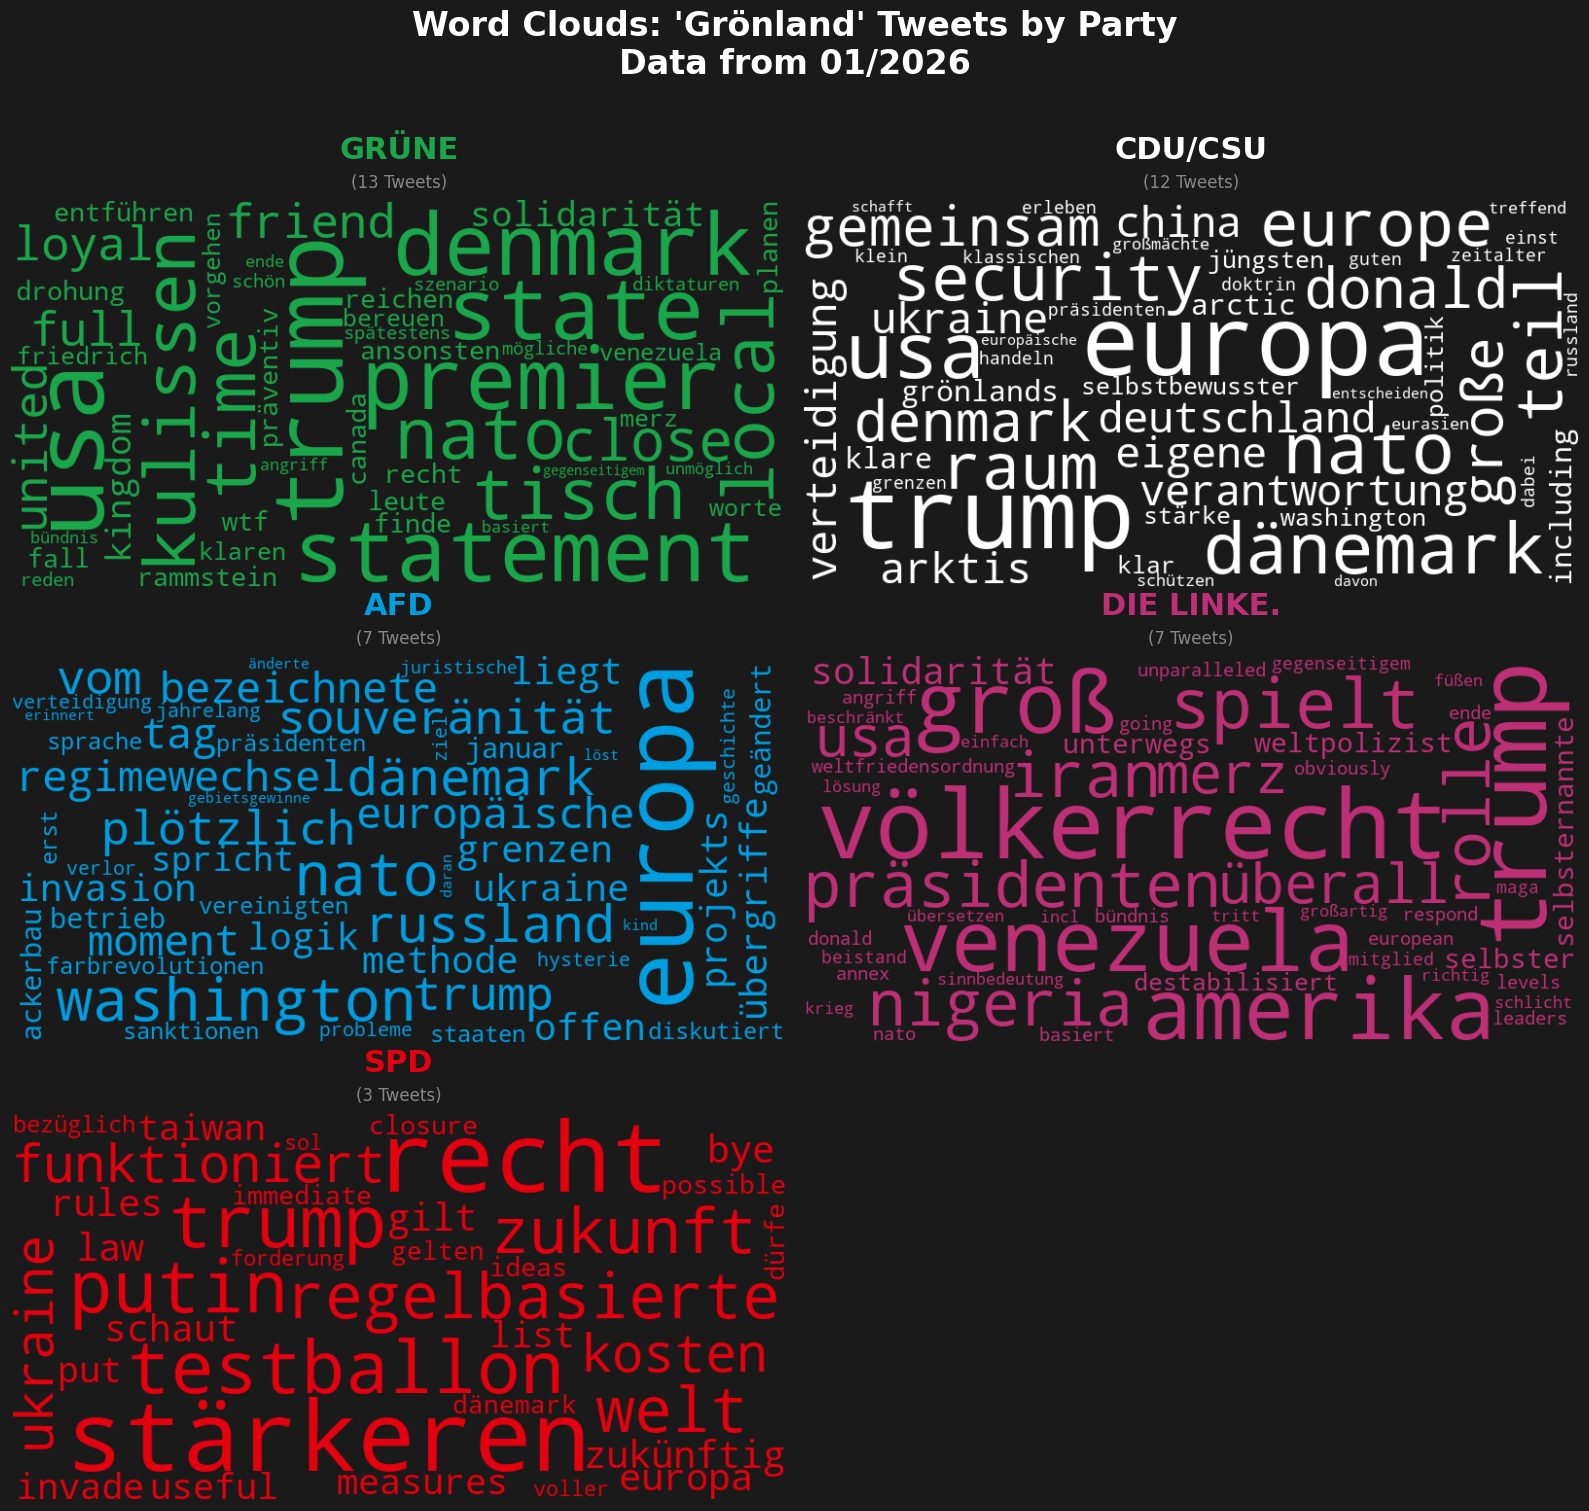

In [30]:
# Generate and display word clouds for each party (bilingual)
def create_combined_wordcloud_figure(parties_to_plot, df_wordcloud, keyword, language='de'):
    """Create combined word cloud figure for all parties."""
    n_parties = len(parties_to_plot)
    if n_parties == 0:
        print("No parties with enough tweets for word clouds")
        return None
    
    # Create a grid of subplots
    n_cols = 2
    n_rows = (n_parties + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
    fig.patch.set_facecolor('#1a1a1a')
    
    # Flatten axes for easier iteration
    if n_parties == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Subtitle text based on language
    tweets_label = "Tweets" if language == 'de' else "Tweets"
    no_words_text = "Nicht genug Wörter" if language == 'de' else "Not enough words"
    
    for idx, party in enumerate(parties_to_plot):
        ax = axes[idx]
        ax.set_facecolor('#1a1a1a')
        
        # Get tweets for this party
        party_texts = df_wordcloud[df_wordcloud['party_norm'] == party]['text'].tolist()
        display_color = get_wordcloud_color_for_party(party)  # Use party color for title
        
        # Create word cloud
        wc = create_party_wordcloud(party, party_texts, keyword)
        
        if wc:
            ax.imshow(wc, interpolation='bilinear')
            # Party name in party color, larger and bold
            ax.set_title(f"{party}\n", color=display_color, fontsize=22, fontweight='bold', pad=5)
            # Add tweet count as smaller subtitle
            ax.text(0.5, 1.02, f"({len(party_texts)} {tweets_label})", 
                   transform=ax.transAxes, ha='center', va='bottom',
                   color='#888888', fontsize=12)
        else:
            ax.text(0.5, 0.5, f"{no_words_text}\n{party}", 
                   ha='center', va='center', color='white', fontsize=14)
            ax.set_title(f"{party}", color=display_color, fontsize=22, fontweight='bold')
        
        ax.axis('off')
    
    # Hide unused subplots
    for idx in range(n_parties, len(axes)):
        axes[idx].set_visible(False)
    
    # Main title based on language
    if language == 'de':
        main_title = f"Word Clouds: '{keyword}'-Tweets nach Partei"
    else:
        main_title = f"Word Clouds: '{keyword}' Tweets by Party"
    
    stand_text = get_stand_text(language)
    fig.suptitle(f"{main_title}\n{stand_text}", 
                color='white', fontsize=24, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    return fig

# Create combined word clouds in both languages
n_parties = len(parties_to_plot)
if n_parties > 0:
    # German version
    fig_wc_de = create_combined_wordcloud_figure(parties_to_plot, df_wordcloud, SINGLE_KEYWORD, language='de')
    save_path_de = GRAPHICS_DIR / f"{SINGLE_KEYWORD.lower()}_wordclouds_all_parties_de.png"
    if fig_wc_de:
        fig_wc_de.savefig(save_path_de, dpi=150, bbox_inches='tight', facecolor='#1a1a1a', edgecolor='none')
        print(f"Saved: {save_path_de.name}")
        plt.close(fig_wc_de)
    
    # English version
    fig_wc_en = create_combined_wordcloud_figure(parties_to_plot, df_wordcloud, SINGLE_KEYWORD, language='en')
    save_path_en = GRAPHICS_DIR / f"{SINGLE_KEYWORD.lower()}_wordclouds_all_parties_en.png"
    if fig_wc_en:
        fig_wc_en.savefig(save_path_en, dpi=150, bbox_inches='tight', facecolor='#1a1a1a', edgecolor='none')
        print(f"Saved: {save_path_en.name}")
        plt.show()
else:
    print("No parties with enough tweets for word clouds")

In [31]:
# Save individual word clouds per party (for social media) - bilingual
print("\nSaving individual word clouds per party (DE + EN)...")

for party in parties_to_plot:
    party_texts = df_wordcloud[df_wordcloud['party_norm'] == party]['text'].tolist()
    display_color = get_wordcloud_color_for_party(party)  # Use party color for title
    
    wc = create_party_wordcloud(party, party_texts, SINGLE_KEYWORD)
    
    if wc:
        # Sanitize party name for filename
        party_filename = party.replace('/', '_').replace(' ', '_').replace('.', '')
        
        # German version
        fig_single_de, ax_single_de = plt.subplots(figsize=(12, 6))
        fig_single_de.patch.set_facecolor('#1a1a1a')
        ax_single_de.set_facecolor('#1a1a1a')
        ax_single_de.imshow(wc, interpolation='bilinear')
        
        # Create two-line title: party name in color, details in gray
        ax_single_de.set_title(f"{party}", color=display_color, fontsize=24, fontweight='bold', pad=15, loc='center')
        ax_single_de.text(0.5, 1.01, f"'{SINGLE_KEYWORD}'-Tweets ({len(party_texts)} Tweets) | {get_stand_text('de')}", 
                         transform=ax_single_de.transAxes, ha='center', va='bottom',
                         color='#888888', fontsize=12)
        ax_single_de.axis('off')
        
        save_path_de = GRAPHICS_DIR / f"{SINGLE_KEYWORD.lower()}_wordcloud_{party_filename}_de.png"
        fig_single_de.savefig(save_path_de, dpi=150, bbox_inches='tight', facecolor='#1a1a1a', edgecolor='none')
        plt.close(fig_single_de)
        
        # English version
        fig_single_en, ax_single_en = plt.subplots(figsize=(12, 6))
        fig_single_en.patch.set_facecolor('#1a1a1a')
        ax_single_en.set_facecolor('#1a1a1a')
        ax_single_en.imshow(wc, interpolation='bilinear')
        
        # Create two-line title: party name in color, details in gray
        ax_single_en.set_title(f"{party}", color=display_color, fontsize=24, fontweight='bold', pad=15, loc='center')
        ax_single_en.text(0.5, 1.01, f"'{SINGLE_KEYWORD}' Tweets ({len(party_texts)} Tweets) | {get_stand_text('en')}", 
                         transform=ax_single_en.transAxes, ha='center', va='bottom',
                         color='#888888', fontsize=12)
        ax_single_en.axis('off')
        
        save_path_en = GRAPHICS_DIR / f"{SINGLE_KEYWORD.lower()}_wordcloud_{party_filename}_en.png"
        fig_single_en.savefig(save_path_en, dpi=150, bbox_inches='tight', facecolor='#1a1a1a', edgecolor='none')
        plt.close(fig_single_en)
        
        print(f"  {party}: {save_path_de.name}, {save_path_en.name}")

print(f"\nIndividual word clouds saved to {GRAPHICS_DIR}")


Saving individual word clouds per party (DE + EN)...
  GRÜNE: grönland_wordcloud_GRÜNE_de.png, grönland_wordcloud_GRÜNE_en.png
  CDU/CSU: grönland_wordcloud_CDU_CSU_de.png, grönland_wordcloud_CDU_CSU_en.png
  AFD: grönland_wordcloud_AFD_de.png, grönland_wordcloud_AFD_en.png
  DIE LINKE.: grönland_wordcloud_DIE_LINKE_de.png, grönland_wordcloud_DIE_LINKE_en.png
  SPD: grönland_wordcloud_SPD_de.png, grönland_wordcloud_SPD_en.png

Individual word clouds saved to /Users/margespinderi/Documents/PoliMetrics/xminer/outputs/202601/graphics/keywords


## Summary

In [32]:
import os

print(f"\n{'='*80}")
print(f"Keyword Analysis Complete!")
print(f"{'='*80}\n")

print(f"Analyzed keyword: {SINGLE_KEYWORD}")
print(f"Additional keywords: {', '.join(KEYWORDS)}\n")

print(f"Charts saved to: {GRAPHICS_DIR}\n")

# List all PNG files
png_files = sorted(GRAPHICS_DIR.glob("*.png"))

# Separate DE and EN files
de_files = [f for f in png_files if '_de.png' in f.name]
en_files = [f for f in png_files if '_en.png' in f.name]

print(f"German charts (_de.png): {len(de_files)}")
for png_file in de_files:
    size = os.path.getsize(png_file) / 1024
    print(f"  {png_file.name} ({size:.1f} KB)")

print(f"\nEnglish charts (_en.png): {len(en_files)}")
for png_file in en_files:
    size = os.path.getsize(png_file) / 1024
    print(f"  {png_file.name} ({size:.1f} KB)")

print(f"\n{len(png_files)} chart(s) ready for social media posting (bilingual)!")


Keyword Analysis Complete!

Analyzed keyword: Grönland
Additional keywords: Grönland, Greenland, Venezuela, Ukraine, Klimawandel, Migration

Charts saved to: /Users/margespinderi/Documents/PoliMetrics/xminer/outputs/202601/graphics/keywords

German charts (_de.png): 11
  grönland_impressions_by_party_de.png (135.5 KB)
  grönland_timeline_de.png (155.1 KB)
  grönland_tweets_by_party_de.png (116.3 KB)
  grönland_wordcloud_AFD_de.png (418.4 KB)
  grönland_wordcloud_CDU_CSU_de.png (310.5 KB)
  grönland_wordcloud_DIE_LINKE_de.png (360.9 KB)
  grönland_wordcloud_GRÜNE_de.png (298.5 KB)
  grönland_wordcloud_SPD_de.png (295.2 KB)
  grönland_wordclouds_all_parties_de.png (1412.3 KB)
  keywords_comparison_by_party_de.png (156.7 KB)
  keywords_heatmap_de.png (187.2 KB)

English charts (_en.png): 11
  grönland_impressions_by_party_en.png (133.8 KB)
  grönland_timeline_en.png (155.5 KB)
  grönland_tweets_by_party_en.png (118.6 KB)
  grönland_wordcloud_AFD_en.png (418.5 KB)
  grönland_wordcloud_CDU